In [1]:
from sklearn import svm,metrics
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from matplotlib import cm
import random

In [2]:
# Load in Data + Transform Direction
df=pd.read_csv('log2transformed_and_normalized_gene_expression_data.csv') # load
df=df.transpose()

genes=df.loc['Unnamed: 0'].to_list() # saves all genes as list
df.columns=genes

samples=df.index.to_list()
samples=samples[1:] # removes the "New_Gene" Label

df=df.drop(['Unnamed: 0']).reset_index(drop=True) # remove gene column 
df.index=samples # set index names 

df=df.astype(float) # weird nonsense step thats needed ~sometimes~
df.head() # show results

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,RPS3P6,GSTM2,ST13P11,RANP6,NAP1L1P3,LINC00671,GAPDHP71,COG8,EIF4E2P1,ARHGAP19
TCGA.A6.5665_Tumor1,12.716704,4.833520,10.605669,9.666432,7.583105,7.746044,11.347351,11.594550,10.737055,10.027522,...,0.000000,8.526498,0.000000,0.938912,1.907370,2.481663,0.000000,9.736349,0.000000,8.861221
TCGA.AA.3662_Healthy,12.728542,4.440389,11.323393,9.904937,8.998116,7.706970,10.133867,12.214890,10.983066,10.429991,...,1.409756,7.478087,0.870630,1.409756,2.108974,0.870630,5.488914,9.867042,0.000000,8.487418
TCGA.A6.2684_Healthy,11.812955,5.701675,10.132944,9.498977,7.727813,8.735967,11.234999,11.428503,11.081855,10.148888,...,1.708694,9.612037,0.000000,0.000000,2.138477,4.077288,1.093779,10.020849,0.000000,9.067167
TCGA.A6.5659_Tumor1,14.650295,6.689371,11.628497,9.949801,9.991783,6.240809,9.251160,10.941951,12.294520,11.672900,...,0.000000,7.407009,0.000000,0.000000,4.465318,2.904814,0.000000,10.547631,9.220101,9.383200
TCGA.AA.3511_Healthy,12.432469,5.258396,12.154352,8.850606,8.023267,9.108951,11.370980,11.932527,11.113362,10.297657,...,2.661122,7.883856,0.916508,0.916508,2.185919,1.872878,3.648240,10.005464,0.000000,8.782451


# Gene signature df

In [3]:
df_gene_sig=df[['TREML2', 'PTPRN', 'PGLYRP1', 'NOG', 'VIP',\
    'RIMKLB', 'NKAIN4', 'FAM171B', 'ZNF417', 'GLRA2', 'HOXA7', 'FABP6', 'MUSK',\
    'HTR6', 'GRIP2', 'VEGFA', 'AKAP12', 'RHEB', 'PMEPA1','GLTP', 'METTL7A',\
    'CITED2', 'SCARA5', 'CDH3','IL6R', 'PKIB', 'GLP2R', 'EPB41L3', 'NR3C2']]

# Genes not found from gene signature (possible naming issues)
# PADI4, NCKIPSD C5orf53 TREML3 HES5 OR8D2 KLRK1 NCRNA00152 PPAP2A LINC00974

df_gene_sig.head(10)

,TREML2,PTPRN,PGLYRP1,NOG,VIP,RIMKLB,NKAIN4,FAM171B,ZNF417,GLRA2,...,GLTP,METTL7A,CITED2,SCARA5,CDH3,IL6R,PKIB,GLP2R,EPB41L3,NR3C2
TCGA.A6.5665_Tumor1,5.163865,7.045953,0.000000,2.481663,10.630085,8.925217,3.970238,7.505138,7.438055,7.065840,...,12.320419,13.399920,11.965595,11.574300,5.235852,11.012812,12.250186,8.858374,11.055709,11.847057
TCGA.AA.3662_Healthy,4.494414,5.566627,1.409756,2.765371,8.883848,7.230001,4.134978,6.968887,7.122600,7.329957,...,11.079559,10.185072,10.063010,8.463916,12.636749,9.847715,8.060350,5.980358,8.926231,9.717484
TCGA.A6.2684_Healthy,5.130507,8.512218,3.625649,4.259210,11.042827,9.282183,4.077288,8.289738,7.466139,4.495193,...,11.973354,13.375031,12.171185,12.763005,5.176484,11.718993,12.312365,8.498709,12.099533,12.006744
TCGA.A6.5659_Tumor1,1.390835,4.106267,4.992032,3.805130,6.919465,9.289066,1.390835,8.249686,11.917585,10.136038,...,10.236458,10.887394,10.581628,7.474363,10.411630,7.447798,7.262062,3.627154,8.804561,9.454988
TCGA.AA.3511_Healthy,3.017981,6.444461,1.472531,2.850558,8.858903,8.409564,5.002881,8.382962,7.238352,4.877810,...,10.939757,11.527948,10.070021,8.283735,12.064537,9.143323,8.808388,4.787968,9.854585,9.599585
TCGA.AZ.6600_Healthy,3.977576,8.669881,3.160928,4.342888,12.103200,10.055780,4.171764,8.539548,7.494323,6.288557,...,11.844244,12.943214,11.804974,12.725764,5.604791,11.635214,11.966696,8.736652,11.906556,12.022857
TCGA.A6.5667_Tumor,4.634540,5.527445,2.394234,1.829520,7.228764,6.590308,4.584222,7.082368,7.953643,6.442794,...,11.128845,9.393930,12.342774,7.161718,12.650770,8.900208,10.341715,5.059747,8.982645,8.871648
TCGA.A6.2685_Tumor,4.916248,8.422069,3.640337,3.376315,12.151396,9.643311,6.502569,8.667484,7.093277,5.550845,...,11.899099,12.661834,11.813086,10.758106,7.732441,11.215730,11.941403,9.227620,11.393996,11.491781
TCGA.A6.2684_Tumor1,3.206278,1.121457,2.511636,5.901671,4.125926,5.550007,0.000000,7.138572,6.816194,0.000000,...,11.054336,9.616860,11.261972,5.813943,11.950234,7.319355,9.069057,3.800364,7.732133,8.527413
TCGA.AA.3655_Healthy,4.446107,8.773972,4.308667,2.310769,10.452634,10.314724,4.510210,8.280703,7.767462,4.074326,...,11.363796,13.159404,11.826820,12.049773,9.089351,11.307408,9.882385,9.046760,11.920838,11.320875


# DeSeq df

In [4]:
df_deseq=pd.read_csv('top_genes.csv') # load
df_deseq.drop(labels=['baseMean','lfcSE','stat','pvalue'],axis=1,inplace=True)
df_deseq.rename(columns={'Unnamed: 0':'genes'},inplace=True)
#num_gens=100;
#df_deseq=df_deseq[:num_gens].copy()
print(np.shape(df_deseq))
df_deseq.head()


df_SEQ=df[df_deseq['genes'].to_list()]
df_SEQ.head()

(267, 3)


,RNU4-2,SNORA73B,RNU4-1,RNY3,SNORA12,SNORA53,SNORD15B,RNU1-11P,SNORA23,SNORA22,...,LRRN3,SLC5A3,CHORDC1_2093,PLAG1,ZNF451,LYPLA1,ALG10,PABIR3,GUSBP1,SLC10A1
TCGA.A6.5665_Tumor1,0.000000,2.700992,1.502923,0.000000,0.000000,1.907370,0.938912,0.000000,0.000000,0.000000,...,6.590610,9.931882,9.158420,6.446350,10.139671,12.274157,6.830370,6.617808,8.383275,3.470914
TCGA.AA.3662_Healthy,1.409756,4.546490,0.000000,0.000000,1.409756,2.108974,2.765371,0.000000,1.409756,1.409756,...,3.557041,10.914748,9.852894,5.591628,10.295708,12.017719,6.708154,6.239579,7.581547,1.801317
TCGA.A6.2684_Healthy,1.093779,2.964573,0.000000,0.000000,1.708694,1.708694,0.000000,0.000000,0.000000,2.138477,...,7.213951,10.397222,9.747661,6.501623,9.949821,11.371584,6.622811,6.446398,6.483449,2.964573
TCGA.A6.5659_Tumor1,15.782877,12.947932,13.669877,8.729353,10.411630,11.636606,10.674774,11.299458,10.778350,11.328872,...,12.092301,13.950209,13.261148,9.557940,13.321837,12.757258,10.569358,9.471567,9.567225,7.636052
TCGA.AA.3511_Healthy,1.872878,3.303842,0.000000,0.000000,0.000000,1.872878,2.442999,0.000000,0.000000,0.916508,...,6.059141,9.745448,10.195440,7.570208,10.066443,11.846131,7.304647,6.968734,7.168865,1.872878


# DeSeq df 2

In [5]:
df2=pd.read_csv("top_genes.csv")
DeSeq2_gene_sig_list = list((df2["Unnamed: 0"]))

df=pd.read_csv("log2transformed_and_normalized_gene_expression_data2.csv") # load
df=df.transpose()

genes=df.loc['new_gene'].to_list() # saves all genes as list
df.columns=genes

df = df[DeSeq2_gene_sig_list]
samples=df.index.to_list()
samples=samples[1:] # removes the "New_Gene" Label

df=df.drop(['new_gene']).reset_index(drop=True) # remove gene column 
df.index=samples # set index names 

df=df.astype(float) # weird nonsense step thats needed ~sometimes~
df.head() # show results



count=0; # keep track of how many genese removed

thresh=25 # min number of samples needed
for col in df.columns.to_list():
    n_zeros=df[col].isin([0]).sum()
    
    if n_zeros >= thresh:
        count+=1
        df.drop([col],axis=1,inplace=True)

print("Removed %d genes. These genes did not meet 10 sample mininum. \nWe have %d genes left \
"%(count,len(df.columns.to_list())))
df_log=pd.DataFrame()
for col in df.columns.to_list():
    df_log[col] = df[col].apply(lambda x: np.log(x+1))
df_log.head()

Removed 42 genes. These genes did not meet 10 sample mininum. 
We have 225 genes left 


,RNU4-2,SNORA73B,RNU4-1,SNORA12,SNORA53,SNORD15B,SNORA23,SNORA22,SNORA38B,ZNF460,...,LRRN3,SLC5A3,CHORDC1_2093,PLAG1,ZNF451,LYPLA1,ALG10,PABIR3,GUSBP1,SLC10A1
TCGA.A6.5665_Tumor1,0.000000,1.308601,0.917459,0.000000,1.067249,0.662127,0.000000,0.000000,0.000000,1.806336,...,2.026912,2.391684,2.318303,2.007724,2.410513,2.585819,2.058010,2.030489,2.238929,1.497593
TCGA.AA.3662_Healthy,0.879525,1.713165,0.000000,0.879525,1.134293,1.325846,0.879525,0.879525,0.879525,1.703732,...,1.516674,2.477777,2.384432,1.885800,2.424423,2.566311,2.042279,1.979563,2.149614,1.030090
TCGA.A6.2684_Healthy,0.738971,1.377398,0.000000,0.996466,0.996466,0.000000,0.000000,1.143738,0.738971,1.841537,...,2.105834,2.433370,2.374688,2.015119,2.393323,2.515402,2.031145,2.007730,2.012694,1.377398
TCGA.A6.5659_Tumor1,2.820359,2.635331,2.685796,2.434633,2.536598,2.457430,2.466263,2.511944,2.242465,2.562808,...,2.572024,2.704725,2.657539,2.356878,2.661785,2.621567,2.448360,2.348664,2.357757,2.155946
TCGA.AA.3511_Healthy,1.055314,1.459508,0.000000,0.000000,1.055314,1.236343,0.000000,0.650505,0.000000,1.700929,...,1.954323,2.374482,2.415507,2.148292,2.403917,2.553043,2.116815,2.075526,2.100330,1.055314


# Random signature

In [6]:
num_genes=100
genes=df.columns.to_list()
# generate random genes
random.seed(32)
n = random.sample(range(0, len(genes)), num_genes)
rand_genes=[genes[i] for i in n]
# subset dataset
rand_df=df[rand_genes].copy()

In [7]:
# Create Target vector
target=[]
sample_names=[]

# loop through and extract tumor + healthy
for i in samples:
    
    temp=i.split('_')[1] # Split string using "_"
    #remove numbers at end (if they have it)
    if temp[-1].isnumeric():
        temp=temp[:-1]
    
    target.append(temp)# save tissues type to list (in order)

        
# Convert to Panda Series
target=pd.Series(target,name='Tissue')

In [8]:
# Convert to binary tumor=(1) + healthy=(0)
target_binary=[]
for i in target:
    if i=='Healthy':
        target_binary.append(0)
    else:
        target_binary.append(1)
        
# Convert to Panda Series
target_binary=pd.Series(target_binary)

# Training with Gene signature: (Not proper, need to reduce dimensions to 2)

In [9]:
# Split Into Training and Test Data
x_train, x_test, y_train, y_test = train_test_split(df_gene_sig, target_binary, test_size=15,shuffle=True, random_state=12)
# display size of 
print('Our Training Data Set has %d patient samples'%(np.shape(x_train)[0]))
print('Our Testing Data Set has %d patient samples'%(np.shape(x_test)[0]))

Our Training Data Set has 40 patient samples
Our Testing Data Set has 15 patient samples


[0 1 0 1 1 1 0 1 0 1 0 0 1 1 1]
Average precision-recall score: 0.76


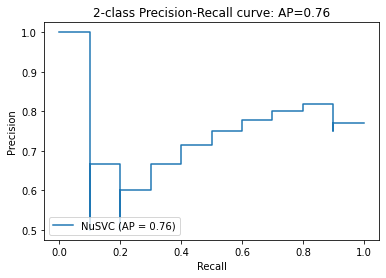

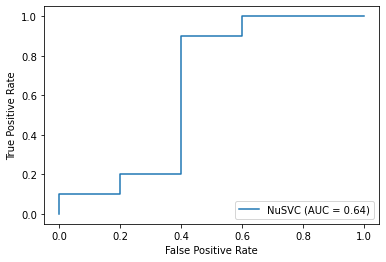

In [10]:
clf = svm.NuSVC(gamma='auto')
clf.fit(x_train, y_train) #fitting model


print(clf.predict(x_test))
y_score = clf.decision_function(x_test)

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))



disp = plot_precision_recall_curve(clf, x_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

metrics.plot_roc_curve(clf, x_test, y_test)
plt.show()


# Training with PCA of gene signature

No handles with labels found to put in legend.


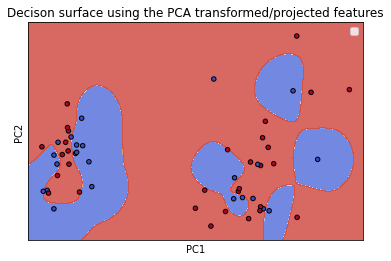

[1 1 1 1 1 1 1 0 0 1 0 0 1 1 1]
Average precision-recall score: 0.87


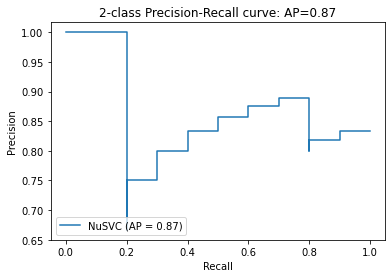

In [11]:
#PCA portion
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(df_gene_sig)

genes = ['TREML2', 'PTPRN', 'PGLYRP1', 'NOG', 'VIP',\
    'RIMKLB', 'NKAIN4', 'FAM171B', 'ZNF417', 'GLRA2', 'HOXA7', 'FABP6', 'MUSK',\
    'HTR6', 'GRIP2', 'VEGFA', 'AKAP12', 'RHEB', 'PMEPA1','GLTP', 'METTL7A',\
    'CITED2', 'SCARA5', 'CDH3','IL6R', 'PKIB', 'GLP2R', 'EPB41L3', 'NR3C2']

pca_cov = pd.DataFrame({"Gene": genes,"PC1_Covariance":abs(pca.components_[0]),"PC2_Covariance":abs(pca.components_[1]) })

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

x_train, x_test, y_train, y_test = train_test_split(Xreduced, target_binary, test_size=15,shuffle=True, random_state=12)

clf2 = svm.NuSVC(gamma='auto')
clf2.fit(x_train,y_train)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf2, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=target_binary, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed/projected features')
ax.legend()
plt.show()

print(clf2.predict(x_test))
y_score = clf2.decision_function(x_test)

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))



disp = plot_precision_recall_curve(clf2, x_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))



c=1
tprs_gene_sig = []
aucs_gene_sig = []
# For interplotting to smooth curve
base_fpr = np.linspace(0, 1, 101)

results = clf2.predict(x_train)

fpr, tpr_svm, thresholds_rf = roc_curve(y_train, results)

auc_k = auc(fpr, tpr_svm)

# acc_temp = round((cm[1,1]+cm[0,0])/45,4)
tpr = np.interp(base_fpr, fpr, tpr_svm)
tpr[0] = 0.0
tprs_gene_sig.append(tpr)
aucs_gene_sig.append(auc_k)
    
plt.show()

# Testing gene sig

In [12]:
# run it foward - to predict using TEST
results=clf2.predict(x_test)

# Generate ROC Curve 
fpr_gs, tpr_gs, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
test_auc_gs = auc(fpr_gs, tpr_gs)

# label for plot
lab='Test'
#plt.plot(fpr_kera, tpr_kera, label=lab)


# show results FOR TEST + Overall Train
print('AUC: %.4f'%(test_auc_gs))

AUC: 0.7500


# Training with PCA of whole gene sig (definitely not proper analysis)

In [13]:
# run it foward - to predict using TEST
results=clf2.predict(x_test)

# Generate ROC Curve 
fpr_gs, tpr_gs, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
test_auc_deseq = auc(fpr_gs, tpr_gs)

# label for plot
lab='Test'
#plt.plot(fpr_kera, tpr_kera, label=lab)


# show results FOR TEST + Overall Train
print('AUC: %.4f'%(test_auc_gs))

AUC: 0.7500


# Training with PCA of DeSeq df 2

No handles with labels found to put in legend.


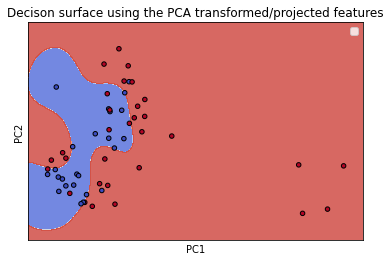

[0 0 1 1 0 0 0 0 0 1 0 0 1 1 0]
Average precision-recall score: 0.84


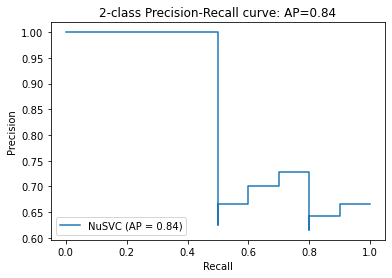

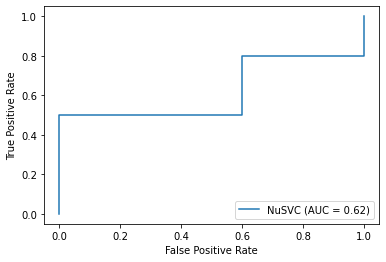

In [14]:
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(df_log)


def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

x_train, x_test, y_train, y_test = train_test_split(Xreduced, target_binary, test_size=15,shuffle=True, random_state=12)

clf2 = svm.NuSVC(gamma='auto')
clf2.fit(x_train,y_train)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf2, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=target_binary, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed/projected features')
ax.legend()
plt.show()

print(clf2.predict(x_test))
y_score = clf2.decision_function(x_test)

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))



disp = plot_precision_recall_curve(clf2, x_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

metrics.plot_roc_curve(clf2, x_test, y_test)

results = clf2.predict(x_train)

c=1
tprs_deseq = []
aucs_deseq = []
# For interplotting to smooth curve
base_fpr = np.linspace(0, 1, 101)


fpr, tpr_svm, thresholds_rf = roc_curve(y_train, results)

auc_k = auc(fpr, tpr_svm)

# acc_temp=round((cm[1,1]+cm[0,0])/45,4)
tpr = np.interp(base_fpr, fpr, tpr_svm)
tpr[0] = 0.0
tprs_deseq.append(tpr)
aucs_deseq.append(auc_k)
    
plt.show()

In [15]:
# run it foward - to predict using TEST
results=clf2.predict(x_test)

# Generate ROC Curve 
fpr_deseq, tpr_deseq, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
test_auc_deseq = auc(fpr_deseq, tpr_deseq)

# label for plot
lab='Test'
#plt.plot(fpr_kera, tpr_kera, label=lab)


# show results FOR TEST + Overall Train
print('AUC: %.4f'%(test_auc_deseq))

AUC: 0.7500


# Training with Random genes

No handles with labels found to put in legend.


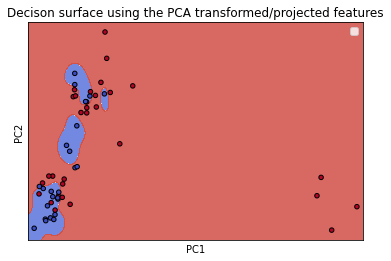

[1 1 1 0 1 0 1 0 1 1 0 0 1 1 1]
Average precision-recall score: 0.92


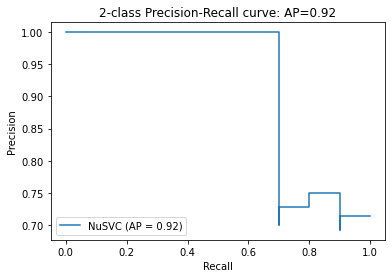

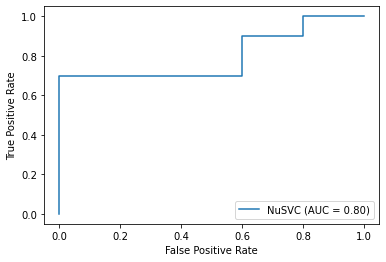

In [23]:
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(rand_df)

x_train, x_test, y_train, y_test = train_test_split(Xreduced, target_binary, test_size=15,shuffle=True, random_state=12)

clf2 = svm.NuSVC(gamma='auto')
clf2 = clf2.fit(x_train,y_train)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf2, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=target_binary, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed/projected features')
ax.legend()
plt.show()

print(clf2.predict(x_test))
y_score = clf2.decision_function(x_test)

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))



disp = plot_precision_recall_curve(clf2, x_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

metrics.plot_roc_curve(clf2, x_test, y_test)

# Intialize counter + Total Accuarcy
c=1
tprs_rand = []
aucs_rand = []
# For interplotting to smooth curve
base_fpr = np.linspace(0, 1, 101)

results = clf2.predict(x_train)

fpr, tpr_svm, thresholds_rf = roc_curve(y_train, results)

auc_k = auc(fpr, tpr_svm)

# acc_temp=round((cm[1,1]+cm[0,0])/45,4)
tpr = np.interp(base_fpr, fpr, tpr_svm)
tpr[0] = 0.0
tprs_rand.append(tpr)
aucs_rand.append(auc_k)
    
plt.show()

In [24]:
# Test Set - now that we've trained, we can now use test set to

# run it foward - to predict using TEST
results=clf2.predict(x_test)

# Generate ROC Curve 
fpr_rand, tpr_rand, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
test_auc_rand = auc(fpr_rand, tpr_rand)

# label for plot
lab='Test'
#plt.plot(fpr_kera, tpr_kera, label=lab)

# Uncomment to print results
print('AUC: %.4f'%(auc_k))

AUC: 0.9286


# Combined plotting

In [18]:
# Stats for std plotting
# Calculate Stats of Training
# Gene sig
tprs_gene_sig = np.array(tprs_gene_sig)
mean_tprs_gs = tprs_gene_sig.mean(axis=0)
std_gs = tprs_gene_sig.std(axis=0)

# deseq
tprs_deseq = np.array(tprs_deseq)
mean_deseq = tprs_deseq.mean(axis=0)
std_deseq = tprs_deseq.std(axis=0)

# random
tprs_rand = np.array(tprs_rand)
mean_rand = tprs_rand.mean(axis=0)
std_rand = tprs_rand.std(axis=0)

# Create First and last point (0,0;1,1) - each dataset
tprs_upper_gs = np.minimum(mean_deseq + std_gs, 1)
tprs_lower_gs = mean_tprs_gs - std_gs

tprs_upper_deseq = np.minimum(mean_deseq + std_deseq, 1)
tprs_lower_deseq = mean_deseq - std_deseq

tprs_upper_rand = np.minimum(mean_rand + std_rand, 1)
tprs_lower_rand = mean_rand - std_rand

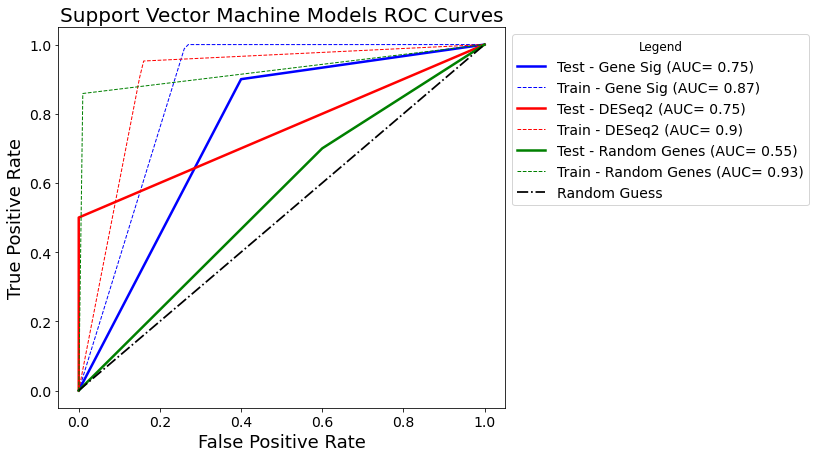

In [22]:
fig =plt.figure(figsize=(8,7))

# Plot Gene Sig
test_label='Test - Gene Sig (AUC= '+str(round(test_auc_gs,2))+')'
plt.plot(fpr_gs, tpr_gs,'b', label=test_label,linewidth=2.5)
train_label='Train - Gene Sig (AUC= '+str(round(sum(aucs_gene_sig),2))+')'
plt.plot(base_fpr, mean_tprs_gs, '--b',label=train_label,linewidth=1)
#plt.fill_between(base_fpr, tprs_lower_gs, tprs_upper_gs, color='grey', alpha=0.3,label='STD 1')


# Plot DESEQ
test_label='Test - DESeq2 (AUC= '+str(round(test_auc_deseq,2))+')'
plt.plot(fpr_deseq, tpr_deseq,'r', label=test_label,linewidth=2.5)
train_label='Train - DESeq2 (AUC= '+str(round(sum(aucs_deseq),2))+')'
plt.plot(base_fpr, mean_deseq, '--r',label=train_label,linewidth=1)
#plt.fill_between(base_fpr, tprs_lower_deseq, tprs_upper_deseq, color='grey', alpha=0.3,label='STD 1')

# Plot Random
test_label='Test - Random Genes (AUC= '+str(round(test_auc_rand,2))+')'
plt.plot(fpr_rand, tpr_rand,'g', label=test_label,linewidth=2.5)
train_label='Train - Random Genes (AUC= '+str(round(sum(aucs_rand),2))+')'
plt.plot(base_fpr, mean_rand, '--g',label=train_label,linewidth=1)
#plt.fill_between(base_fpr, tprs_lower_rand, tprs_upper_rand, color='grey', alpha=0.3,label='STD 1')


# Labels and Plot settings
plt.plot([0, 1], [0, 1],'-.k',label='Random Guess',linewidth=1.75)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.title('Support Vector Machine Models ROC Curves',fontsize=20)
plt.legend(title='Legend', bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)
plt.rcParams['legend.title_fontsize'] = 'large'
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()